## Goal of notebook

This notebook accompanies [sSVN](https://github.com/leviyevalex/sSVN), and provides an example of how to run on the hybrid Rosenbrock. The hybrid Rosenbrock is a very convenient benchmark.
1. It is easily adapted to any number of dimensions $D \ge 2$.
2. Each marginal is a long and narrow ridge. These are notoriously difficult for sampling algorithms to resolve.
3. It may be analytically sampled, providing a computationally trivial way to compare the quality of samples obtained via various methods/algorithms.
4. Most importantly, it closely resembles many geometries often encountered in practice (e.g, https://arxiv.org/abs/2106.15163).

In this notebook we compare the performance of SVGD and sSVN on a ten-dimensional hybrid Rosenbrock. We encourage the reader to tinker with the settings of the hybrid Rosenbrock, `eps`, and `nParticles`. The reader will find that sSVN is much more stable than sSVGD. That is, sSVN may be evolved with a much larger `eps`.

## Import tools

In [1]:
import sys
sys.path.append("..")

from models.JAXHRD import hybrid_rosenbrock
from models.multivariate_gaussian import multivariate_gaussian
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
%matplotlib inline
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import corner

## Setup hybrid Rosenbrock model

In [2]:
# Hybrid Rosenbrock
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B)
ground_truth = model.newDrawFromPosterior(100000)

In [ ]:
# Gaussian
DoF = 10
mu = np.zeros(DoF)
sigma = np.random.uniform(low=1, high=10, size=DoF) # covariance matrix
model = multivariate_gaussian(mu, sigma)
ground_truth_samples = model.newDrawFromLikelihood(100000)

## Run sSVGD dynamics

Remark: sSVGD is unstable with eps=0.01. Try it!

In [3]:
nParticles = 100
# kernelKwargs = {'kernel_type': 'RBF', 'nFeatures':nParticles}
kernelKwargs = {'h':model.DoF * 10} # RBF
# kernelKwargs = {'h':model.DoF, 'p':0.5} # Lp
sampler1 = samplers(model=model, nIterations=100, nParticles=nParticles, profile=False, kernel_type='RFG')
sampler1.apply(method='sSVN', eps=1, kernelKwargs=kernelKwargs)

Stepsize 1.000000 | Median bandwidth: 3.829090: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


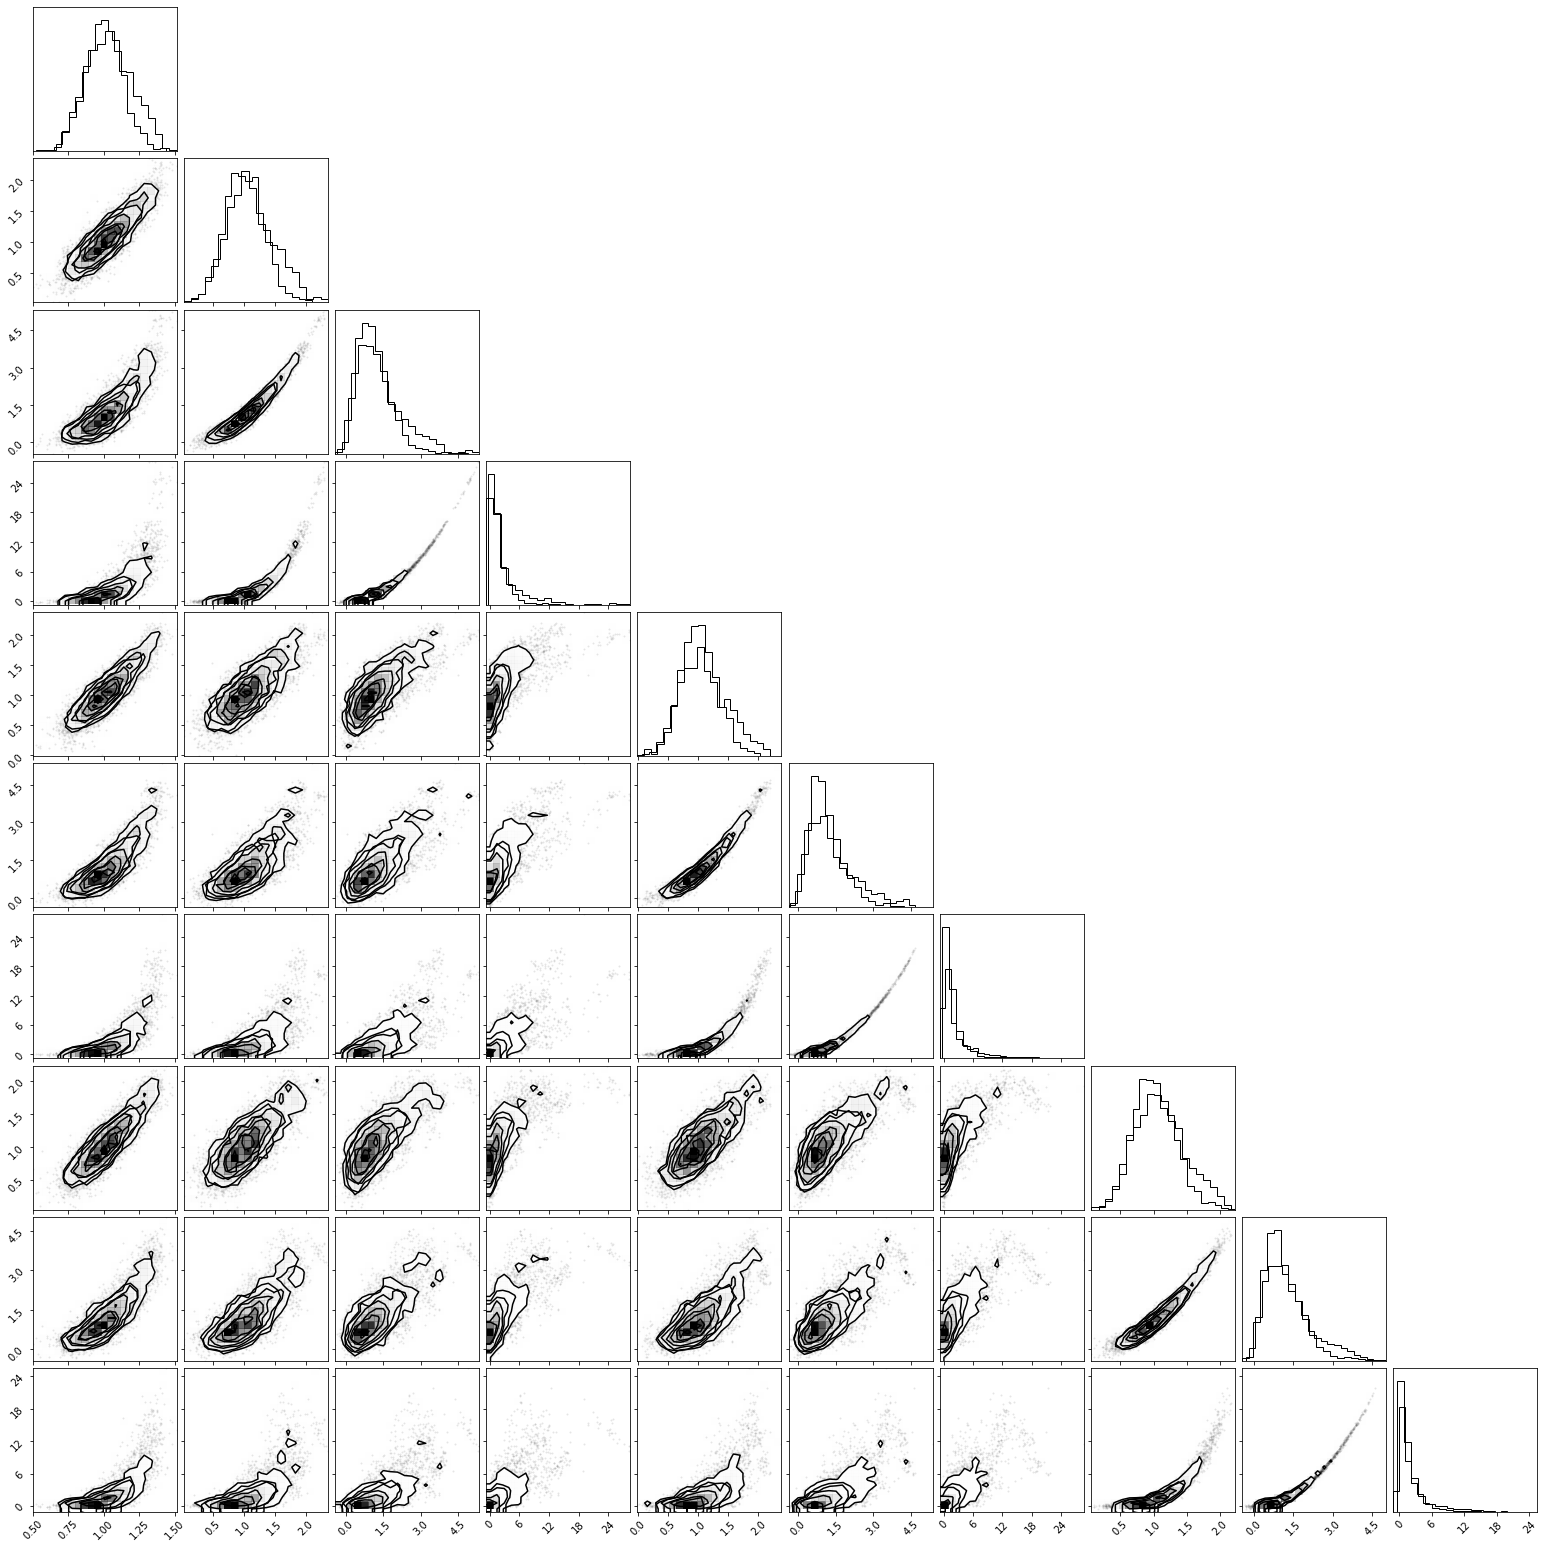

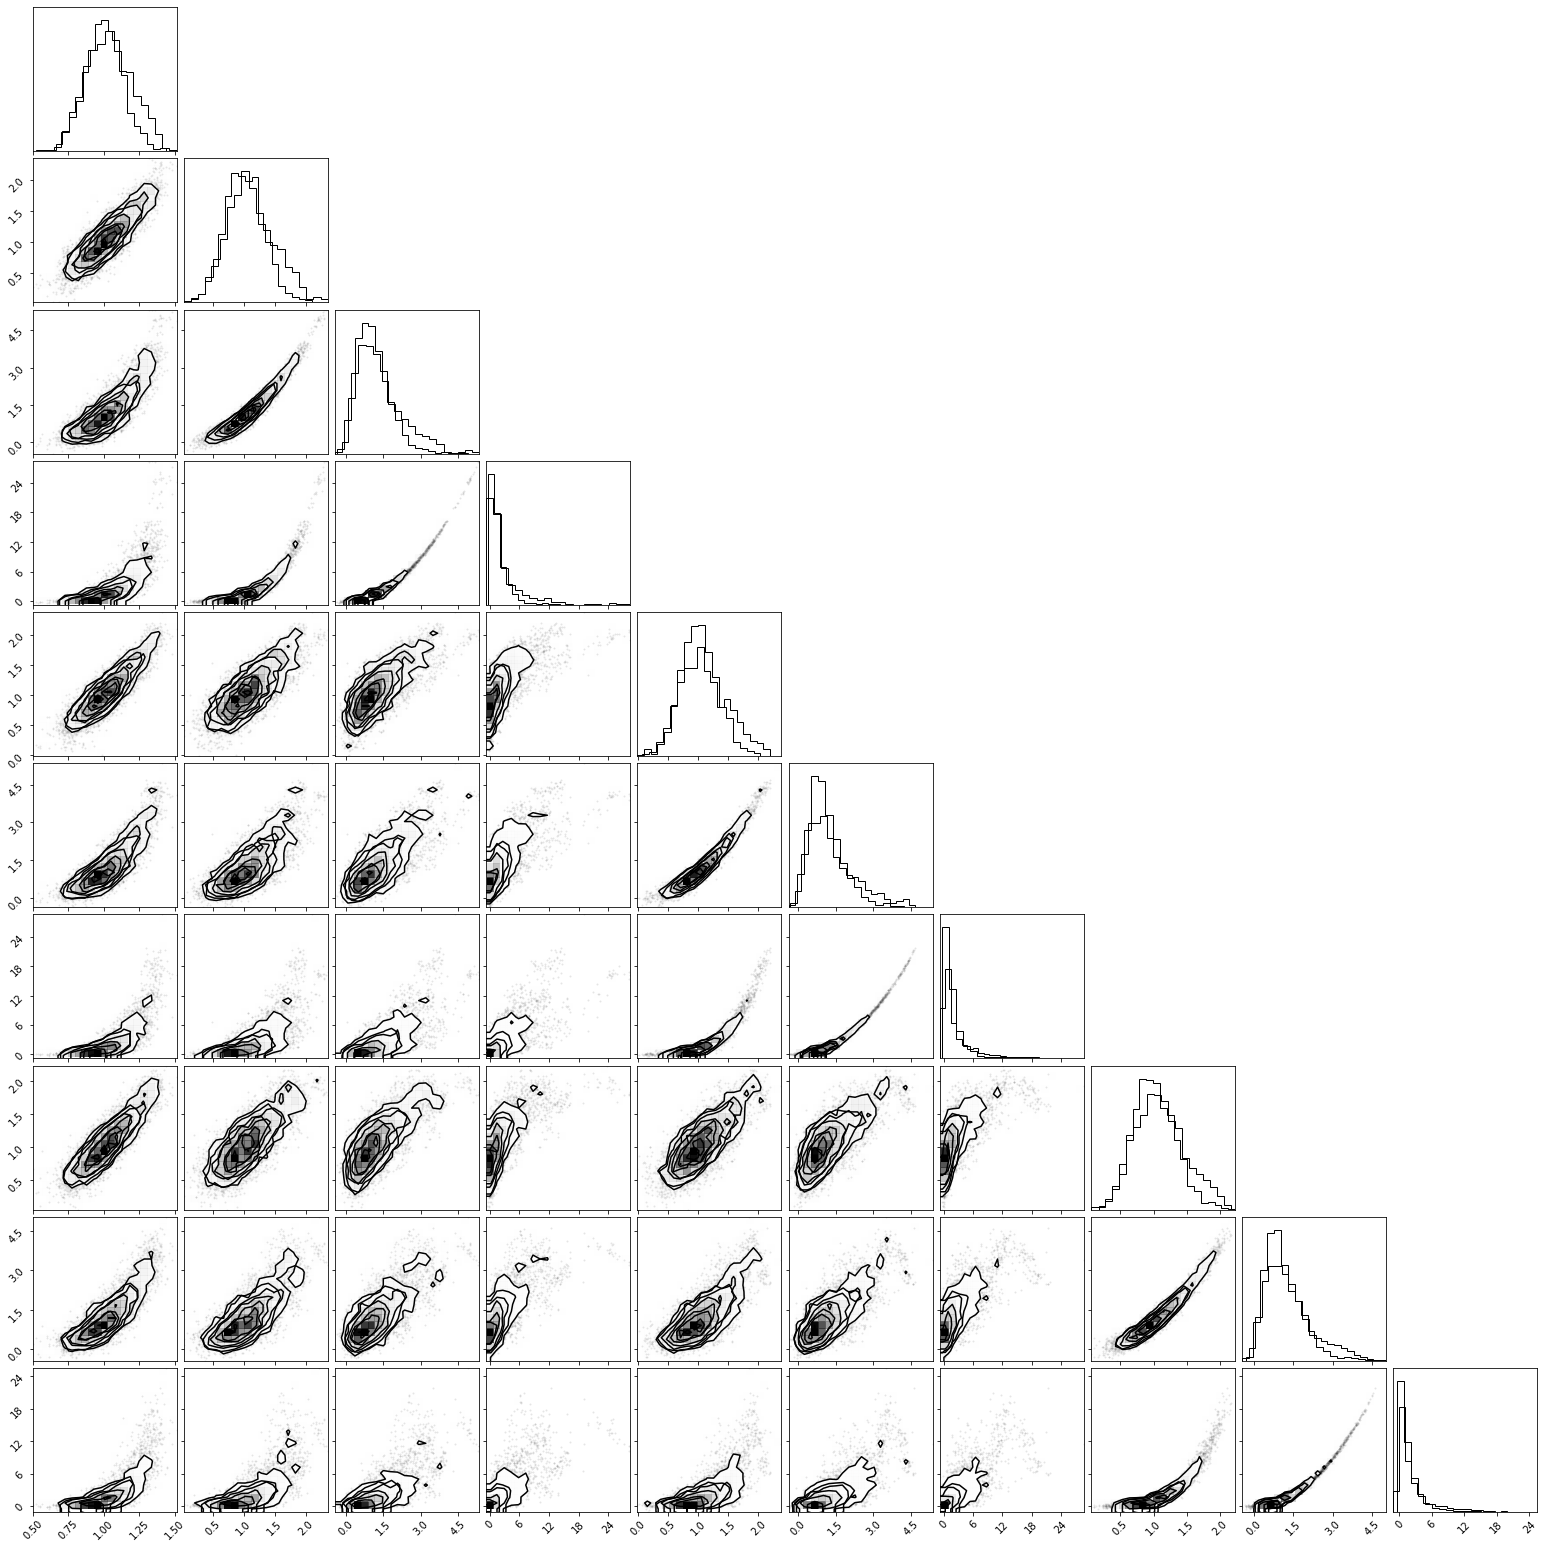

In [4]:
# %%capture
X1 = collect_samples(sampler1.history_path)
fig1 = corner.corner(X1)
ground_truth_samples=model.newDrawFromPosterior(1000000)
corner.corner(ground_truth_samples[0:X1.shape[0]], fig=fig1)

## Run sSVN dynamics

In [12]:
from scripts.plot_helper_functions import extract_velocity_norms, extract_gmlpt_norm
import matplotlib.pyplot as plt
norms = extract_velocity_norms(sampler1.history_path)
gmlpt_norm = extract_gmlpt_norm(sampler1.history_path)


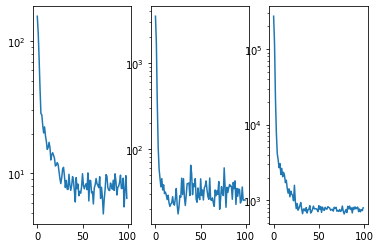

In [15]:
# Convergence criteria

fig, axs = plt.subplots(1, 3)
# axs[0].plot(model.fgrid, L1_response.squeeze())
axs[0].plot(norms['vsvn'])
axs[0].set_yscale('log')
axs[1].plot(norms['vsvgd'])
axs[1].set_yscale('log')
axs[2].plot(gmlpt_norm)
axs[2].set_yscale('log')







Text(0.5, 0, 'Iteration')

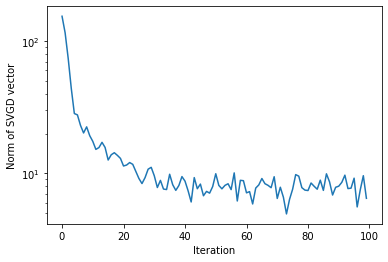

In [11]:
plt.yscale('log')
plt.plot(norms['vsvn'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

# norms['vsvn']

KeyError: 'v_svgd'

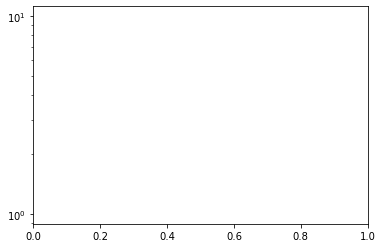

In [7]:
plt.yscale('log')
plt.plot(norms['v_svgd'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

In [ ]:
sampler2 = samplers(model=model, nIterations=100, nParticles=100, profile=False)
sampler2.apply(method='sSVN', eps=0.1)

In [ ]:
%%capture
X2 = collect_samples(sampler2.history_path)
fig2 = corner.corner(X2)

In [ ]:
corner.corner(ground_truth_samples[0:X2.shape[0]], fig=fig2)